In [1]:
import cv2
import numpy as np
import os 
import matplotlib.pyplot as plt

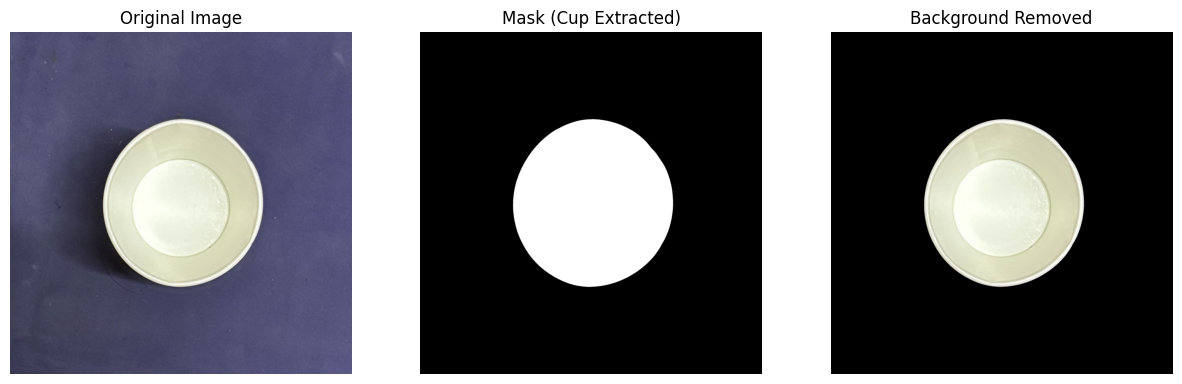

In [2]:
def save_background_removed_dataset(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for label_dir in ["defected", "non_defected"]:
        in_path = os.path.join(input_dir, label_dir)
        out_path = os.path.join(output_dir, label_dir)
        os.makedirs(out_path, exist_ok=True)

        for img_name in os.listdir(in_path):
            img_path = os.path.join(in_path, img_name)
            _, _, result = remove_background(img_path)

            # Save image (same filename)
            save_path = os.path.join(out_path, img_name)
            cv2.imwrite(save_path, result)

    print(f"Background-removed dataset saved at: {output_dir}")

def remove_background(img_path):
    img = cv2.imread(img_path)
    output = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold: keep bright areas (cup), remove dark background
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological cleanup (remove noise, smooth edges)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Apply mask to original image
    result = cv2.bitwise_and(output, output, mask=mask)
    return img, mask, result

# Pick a sample image
sample_img = "dataset/defected/IMG_9183 Top Cup 1 (2).jpg"  # change path to one of your images

original, mask, result = remove_background(sample_img)

# Convert to RGB for matplotlib
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(original_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask (Cup Extracted)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(result_rgb)
plt.title("Background Removed")
plt.axis('off')

plt.show()


In [3]:
save_background_removed_dataset("dataset", "dataset_cleaned")


Background-removed dataset saved at: dataset_cleaned


Edge Detection

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_outer_contour(img_path, show=True):
    # Load background-removed image
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold to get binary image
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Select the largest contour = cup outer edge
        outer_contour = max(contours, key=cv2.contourArea)

        # Draw contour on a copy
        img_contour = img.copy()
        cv2.drawContours(img_contour, [outer_contour], -1, (0, 255, 0), 2)

        if show:
            plt.figure(figsize=(6,6))
            plt.imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
            plt.title("Detected Cup Circumference")
            plt.axis("off")
            plt.show()

        return outer_contour
    else:
        print("⚠️ No contour found")
        return None


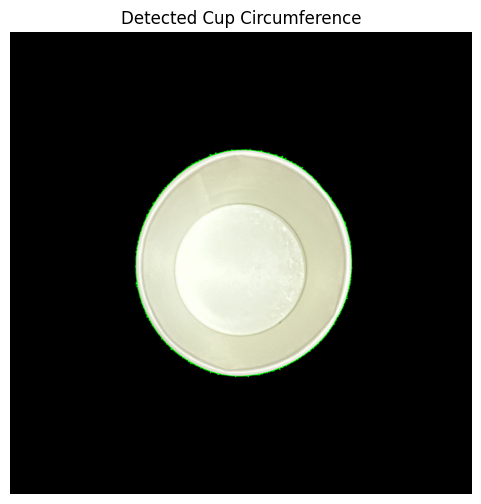

array([[[1069,  521]],

       [[1068,  522]],

       [[1069,  523]],

       ...,

       [[1068,  522]],

       [[1069,  521]],

       [[1070,  521]]], shape=(3150, 1, 2), dtype=int32)

In [13]:
detect_outer_contour("dataset_cleaned/defected/IMG_9183 Top Cup 1 (2).jpg")


Cup circumference


Outer edges to images

In [5]:
def save_outer_contour_dataset(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # loop through defected/non_defected
    for label in ["defected", "non_defected"]:
        in_folder = os.path.join(input_dir, label)
        out_folder = os.path.join(output_dir, label)
        os.makedirs(out_folder, exist_ok=True)

        for fname in os.listdir(in_folder):
            img_path = os.path.join(in_folder, fname)
            img = cv2.imread(img_path)

            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # largest contour = cup circumference
                outer_contour = max(contours, key=cv2.contourArea)

                # blank canvas same size
                contour_img = np.zeros_like(img)

                # draw outer contour in white
                cv2.drawContours(contour_img, [outer_contour], -1, (255, 255, 255), 2)

                # save
                out_path = os.path.join(out_folder, fname)
                cv2.imwrite(out_path, contour_img)

    print(f"✅ Saved outer contour dataset to: {output_dir}")


In [6]:
save_outer_contour_dataset("dataset_cleaned", "dataset_outer_contour")


✅ Saved outer contour dataset to: dataset_outer_contour


using couter data-->radius

In [8]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import math

# ------------------- CONFIG -------------------
BASE_DIR = Path(r"D:\manu project\new\dataset_outer_contour")  # <— your root folder
SUBFOLDERS = {
    "defected": 0,       # label mapping
    "non_defected": 1,
}
ANGLE_STEP = 10          # degrees
# Output folder directly in "D:\manu project\new"
OUT_DIR = Path(r"D:\manu project\new")
OUT_IMG_DIR = OUT_DIR / "annotated"
OUT_CSV = OUT_DIR / "radii_all_images.csv"
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
USE_HOUGH = False        # set True if your shapes are perfect circles
# ------------------------------------------------

def largest_external_contour(bin_img):
    cnts, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        raise ValueError("No contour found.")
    return max(cnts, key=cv2.contourArea)

def estimate_center_and_radius(cnt):
    (cx, cy), r = cv2.minEnclosingCircle(cnt)
    return (float(cx), float(cy)), float(r)

def ray_hit_point(edge_img, center, theta_deg, max_step=None):
    """Cast a ray from center at theta_deg (degrees) until it hits a white pixel."""
    h, w = edge_img.shape[:2]
    cx, cy = center
    theta = math.radians(theta_deg)
    cos_t, sin_t = math.cos(theta), math.sin(theta)

    if max_step is None:
        max_step = int(2 * math.hypot(w, h))

    for r in range(1, max_step):
        x = int(round(cx + r * cos_t))
        y = int(round(cy + r * sin_t))
        if x < 0 or y < 0 or x >= w or y >= h:
            # went out of bounds without a hit
            return None, float("nan")
        if edge_img[y, x] > 0:  # hit the ring
            return (x, y), float(r)
    return None, float("nan")

def process_image(img_path, angle_step=10, use_hough=False):
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not read: {img_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold to extract the ring
    _, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bin_thick = cv2.dilate(bin_img, np.ones((3,3), np.uint8), iterations=1)

    # get center from largest contour
    cnt = largest_external_contour(bin_thick)
    (cx, cy), _ = estimate_center_and_radius(cnt)

    if use_hough:
        blur = cv2.GaussianBlur(gray, (9, 9), 2)
        circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.2,
                                   minDist=min(gray.shape)//4,
                                   param1=100, param2=20,
                                   minRadius=0, maxRadius=0)
        if circles is not None:
            c = circles[0][0]
            cx, cy = float(c[0]), float(c[1])

    center = (cx, cy)

    angles = list(range(0, 360, angle_step))
    radii = []
    overlay = img.copy()

    for ang in angles:
        hit, r = ray_hit_point(bin_thick, center, ang)
        radii.append(r)
        if hit is not None:
            cv2.line(overlay, (int(round(cx)), int(round(cy))), hit, (0, 255, 0), 1)

    # mark center
    cv2.circle(overlay, (int(round(cx)), int(round(cy))), 3, (0, 0, 255), -1)
    out_img = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

    return out_img, (cx, cy), angles, radii

def main():
    OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
    rows = []

    # Prepare CSV header: file, label, center_x, center_y, r_000, r_010, ...
    angle_cols = [f"r_{a:03d}" for a in range(0, 360, ANGLE_STEP)]

    for sub, label in SUBFOLDERS.items():
        subdir = BASE_DIR / sub
        if not subdir.exists():
            print(f"Warning: {subdir} not found, skipping.")
            continue

        for p in sorted(subdir.rglob("*")):
            if p.suffix.lower() not in IMG_EXTS:
                continue

            try:
                annotated, (cx, cy), angles, radii = process_image(p, ANGLE_STEP, USE_HOUGH)
            except Exception as e:
                print(f"[ERROR] {p}: {e}")
                continue

            # Save annotated image, mirroring folder structure
            rel = p.relative_to(BASE_DIR)
            out_img_path = OUT_IMG_DIR / rel.with_suffix(".png")
            out_img_path.parent.mkdir(parents=True, exist_ok=True)
            cv2.imwrite(str(out_img_path), annotated)

            row = {
                "file": str(rel).replace("\\", "/"),
                "defect_status": label,   # 0 for defected, 1 for non_defected
                "center_x": cx,
                "center_y": cy,
            }
            row.update({col: r for col, r in zip(angle_cols, radii)})
            rows.append(row)
            print(f"Processed: {rel}  ->  center=({cx:.2f}, {cy:.2f}), saved {out_img_path}")

    # Write combined CSV
    df = pd.DataFrame(rows, columns=["file", "defect_status", "center_x", "center_y"] + angle_cols)
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    df.to_csv(OUT_CSV, index=False)
    print(f"\nSaved CSV with {len(df)} rows to: {OUT_CSV}")

if __name__ == "__main__":
    main()

Processed: defected\IMG_9183 Top Cup 1 (2).JPG  ->  center=(1034.04, 1029.04), saved D:\manu project\new\annotated\defected\IMG_9183 Top Cup 1 (2).png
Processed: defected\IMG_9186 Top Cup 2 (2).JPG  ->  center=(1103.47, 1193.94), saved D:\manu project\new\annotated\defected\IMG_9186 Top Cup 2 (2).png
Processed: defected\IMG_9189 Top Cup 3 (2).JPG  ->  center=(1387.46, 1362.73), saved D:\manu project\new\annotated\defected\IMG_9189 Top Cup 3 (2).png
Processed: defected\IMG_9192 Top Cup 4 (2).JPG  ->  center=(803.90, 1130.23), saved D:\manu project\new\annotated\defected\IMG_9192 Top Cup 4 (2).png
Processed: defected\IMG_9195 Top Cup 5 (2).JPG  ->  center=(1086.80, 1125.76), saved D:\manu project\new\annotated\defected\IMG_9195 Top Cup 5 (2).png
Processed: defected\IMG_9198 Top Cup 6 (2).JPG  ->  center=(1121.13, 1116.81), saved D:\manu project\new\annotated\defected\IMG_9198 Top Cup 6 (2).png
Processed: defected\IMG_9201 Top Cup 7 (2).JPG  ->  center=(824.90, 850.13), saved D:\manu proj

Using radius data

In [11]:
import pandas as pd

# Load your CSV
df = pd.read_csv("radii_all_images.csv")

# Select only the radius columns
radius_cols = [c for c in df.columns if c.startswith("r_")]

# Compute min, max, and ratio
df["r_min"] = df[radius_cols].min(axis=1)
df["r_max"] = df[radius_cols].max(axis=1)
df["r_ratio"] = df["r_max"] / df["r_min"]

# Save updated CSV
df.to_csv("radii_all_images_with_ratios.csv", index=False)

# Show a preview
df.head()

# Create new dataframe with only r_ratio and defect_status
main = df[["r_ratio", "defect_status"]].copy()

main.to_csv("final_data_filewith_ratios.csv", index=False)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

X = main[["r_ratio"]].values
y = main["defect_status"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# ------------------ Save model as pickle ------------------
with open("defect_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as defect_model.pkl")


Accuracy: 0.9666666666666667
Model saved as defect_model.pkl


In [17]:
import pickle
import numpy as np

# Load the model
with open("defect_model.pkl", "rb") as f:
    model = pickle.load(f)

# Predict for a new r_ratio
new_r_ratio = np.array([[1.25]])  # example
prediction = model.predict(new_r_ratio)
print("Defect status:", prediction[0])  # 0 = defected, 1 = non-defected


Defect status: 0


Train the model using CNN

old tried version which has accuracy 57%

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Paths
train_dir = "dataset_outer_contour"  # contains defected/ and non_defected/

# Image generator (rescale and augment)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # resize to same size
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen, validation_data=val_gen, epochs=15)

# Save model
model.save("cup_defect_cnn.h5")


Found 240 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


d:\manu project\ml_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\manu project\ml_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 849ms/step - accuracy: 0.5167 - loss: 0.7009 - val_accuracy: 0.5167 - val_loss: 0.6960
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 623ms/step - accuracy: 0.5042 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 0.5542 - loss: 0.6876 - val_accuracy: 0.5167 - val_loss: 0.6944
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 511ms/step - accuracy: 0.6083 - loss: 0.6791 - val_accuracy: 0.5333 - val_loss: 0.6959
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 539ms/step - accuracy: 0.6208 - loss: 0.6640 - val_accuracy: 0.5000 - val_loss: 0.7044
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 0.6083 - loss: 0.6381 - val_accuracy: 0.4833 - val_loss: 0.7191
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - accuracy: 0.6875 - loss: 0.6060 - val_accuracy: 0.5667 - val_loss: 0.7015
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - accuracy: 0.7833 - loss: 0.5349 - val_accuracy: 0.5667 - val_loss: